In [ ]:
!pip install kaggle

from google.colab import files
files.upload()  

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!chmod 600 /content/kaggle.json

!kaggle datasets download -d omkargurav/face-mask-dataset

import zipfile

with zipfile.ZipFile('face-mask-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/face-mask-dataset')

import os

data_dir = '/content/face-mask-dataset'
print("الملفات الموجودة في مجموعة البيانات:")
print(os.listdir(data_dir))

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
 86% 141M/163M [00:00<00:00, 228MB/s]
100% 163M/163M [00:00<00:00, 211MB/s]
الملفات الموجودة في مجموعة البيانات:
['data']


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping , ModelCheckpoint

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(
    rescale=1./255,         
    shear_range=0.2,       
    zoom_range=0.2,         
    horizontal_flip=True, 
    validation_split=0.2    

val_data_gen = ImageDataGenerator(
    rescale=1./255,         
    validation_split=0.2    
)

# تحميل بيانات التدريب
train_data = train_data_gen.flow_from_directory(
    '/content/face-mask-dataset/data', 
    target_size=(224, 224),            
    batch_size=32,                     
    class_mode='binary',               
    classes=['with_mask', 'without_mask'], 
    subset='training'                  
)

validation_data = train_data_gen.flow_from_directory(
    '/content/face-mask-dataset/data',  
    target_size=(224, 224),            
    batch_size=32,                   
    class_mode='binary',               
    classes=['with_mask', 'without_mask'], 
    subset='validation'                 



Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.
Found 7553 images belonging to 2 classes.


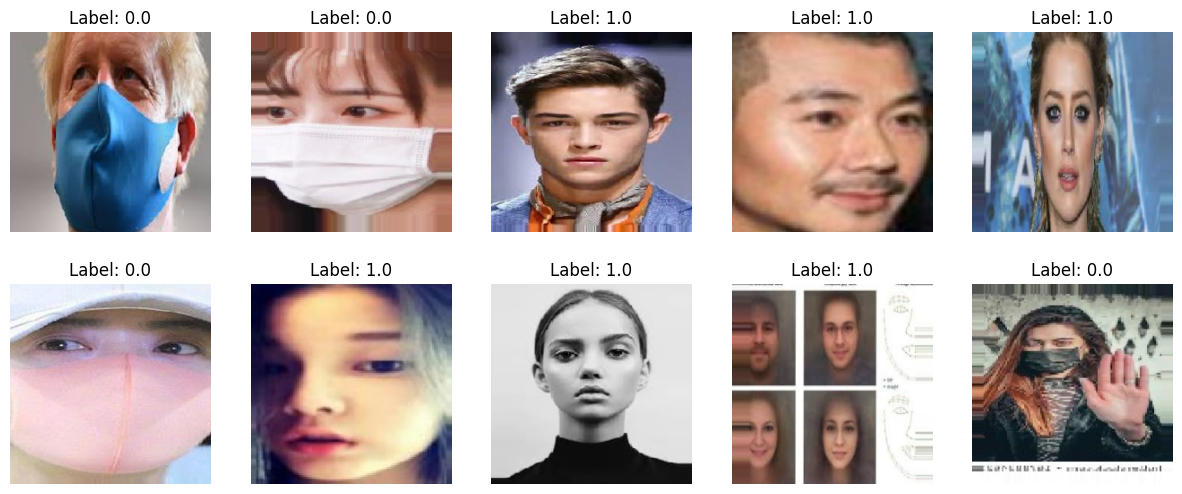

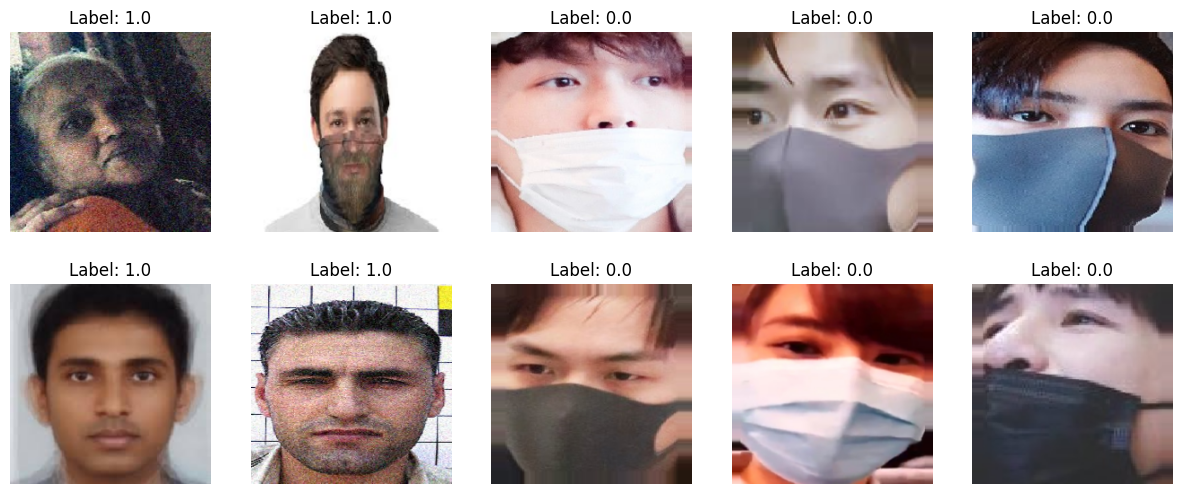

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    img, label = next(train_data) 
    axes[i//5, i%5].imshow(img[0])
    axes[i//5, i%5].set_title(f"Label: {label[0]}")
    axes[i//5, i%5].axis('off')
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    img, label = next(validation_data) 
    axes[i//5, i%5].imshow(img[0])
    axes[i//5, i%5].set_title(f"Label: {label[0]}")
    axes[i//5, i%5].axis('off')
plt.show()

In [6]:
callbacks = [
    ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4, verbose = 1, min_lr = 1e-6),
    EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1),
    ModelCheckpoint(filepath = 'model.h5', monitor = 'val_loss', save_best_only = True, verbose = 1)
]

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
base_model.trainable = False
def get_pretrained():

    inputs = layers.Input(shape=(224, 224, 3))

    x = base_model(inputs)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    output = layers.Dense(1, activation='sigmoid')(x)

    model1 = keras.Model(inputs=[inputs], outputs=output)

    return model1
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_pretrained.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
history = model_pretrained.fit(
    train_data,
    epochs = 20,
    validation_data = validation_data,
    callbacks = callbacks
)

Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7399 - loss: 0.5150
Epoch 1: val_loss improved from inf to 0.30444, saving model to model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 122s 573ms/step - accuracy: 0.7404 - loss: 0.5143 - val_accuracy: 0.8715 - val_loss: 0.3044 - learning_rate: 0.0010
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9235 - loss: 0.2170
Epoch 2: val_loss improved from 0.30444 to 0.19985, saving model to model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 94s 499ms/step - accuracy: 0.9236 - loss: 0.2169 - val_accuracy: 0.9238 - val_loss: 0.1998 - learning_rate: 0.0010
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9523 - loss: 0.1502
Epoch 3: val_loss improved from 0.19985 to 0.17101, saving model to model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 142s 502ms/step - accuracy: 0.9523 - loss: 0.1502 - val_accuracy: 0.9377 - val_loss: 0.1710 - learning_rate: 0.0010
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9585 - loss: 0.1177
Epoch 4: val_loss improved from 0.17101 to 0.16315, saving model to model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 94s 497ms/step - accuracy: 0.9585 - loss: 0.1177 - val_accuracy: 0.9364 - val_loss: 0.1632 - learning_rate: 0.0010
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9616 - loss: 0.1155
Epoch 5: val_loss improved from 0.16315 to 0.14174, saving model to model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 95s 503ms/step - accuracy: 0.9616 - loss: 0.1155 - val_accuracy: 0.9437 - val_loss: 0.1417 - learning_rate: 0.0010
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9639 - loss: 0.1031
Epoch 6: val_loss improved from 0.14174 to 0.12993, saving model to model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 95s 503ms/step - accuracy: 0.9639 - loss: 0.1031 - val_accuracy: 0.9464 - val_loss: 0.1299 - learning_rate: 0.0010
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9611 - loss: 0.1015
Epoch 7: val_loss did not improve from 0.12993
189/189 ━━━━━━━━━━━━━━━━━━━━ 95s 501ms/step - accuracy: 0.9611 - loss: 0.1015 - val_accuracy: 0.9192 - val_loss: 0.1979 - learning_rate: 0.0010
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9607 - loss: 0.0993
Epoch 8: val_loss improved from 0.12993 to 0.12956, saving model to model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 95s 503ms/step - accuracy: 0.9608 - loss: 0.0993 - val_accuracy: 0.9483 - val_loss: 0.1296 - learning_rate: 0.0010
Epoch 9/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9709 - loss: 0.0813
Epoch 9: val_loss improved from 0.12956 to 0.10633, saving model to model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 97s 514ms/step - accuracy: 0.9709 - loss: 0.0813 - val_accuracy: 0.9583 - val_loss: 0.1063 - learning_rate: 0.0010
Epoch 10/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9698 - loss: 0.0821
Epoch 10: val_loss did not improve from 0.10633
189/189 ━━━━━━━━━━━━━━━━━━━━ 97s 510ms/step - accuracy: 0.9698 - loss: 0.0821 - val_accuracy: 0.9510 - val_loss: 0.1343 - learning_rate: 0.0010
Epoch 11/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9716 - loss: 0.0810
Epoch 11: val_loss did not improve from 0.10633
189/189 ━━━━━━━━━━━━━━━━━━━━ 94s 499ms/step - accuracy: 0.9716 - loss: 0.0810 - val_accuracy: 0.9550 - val_loss: 0.1162 - learning_rate: 0.0010
Epoch 12/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9759 - loss: 0.0713
Epoch 12: val_loss did not improve from 0.10633
189/189 ━━━━━━━━━━━━━━━━━━━━ 95s 500ms/step - accuracy: 0.9758 - loss: 0.0713 - val_accuracy: 0.9536 - val_loss: 0.1096 - learning_rate: 0.0010
Epoch 13/20
1

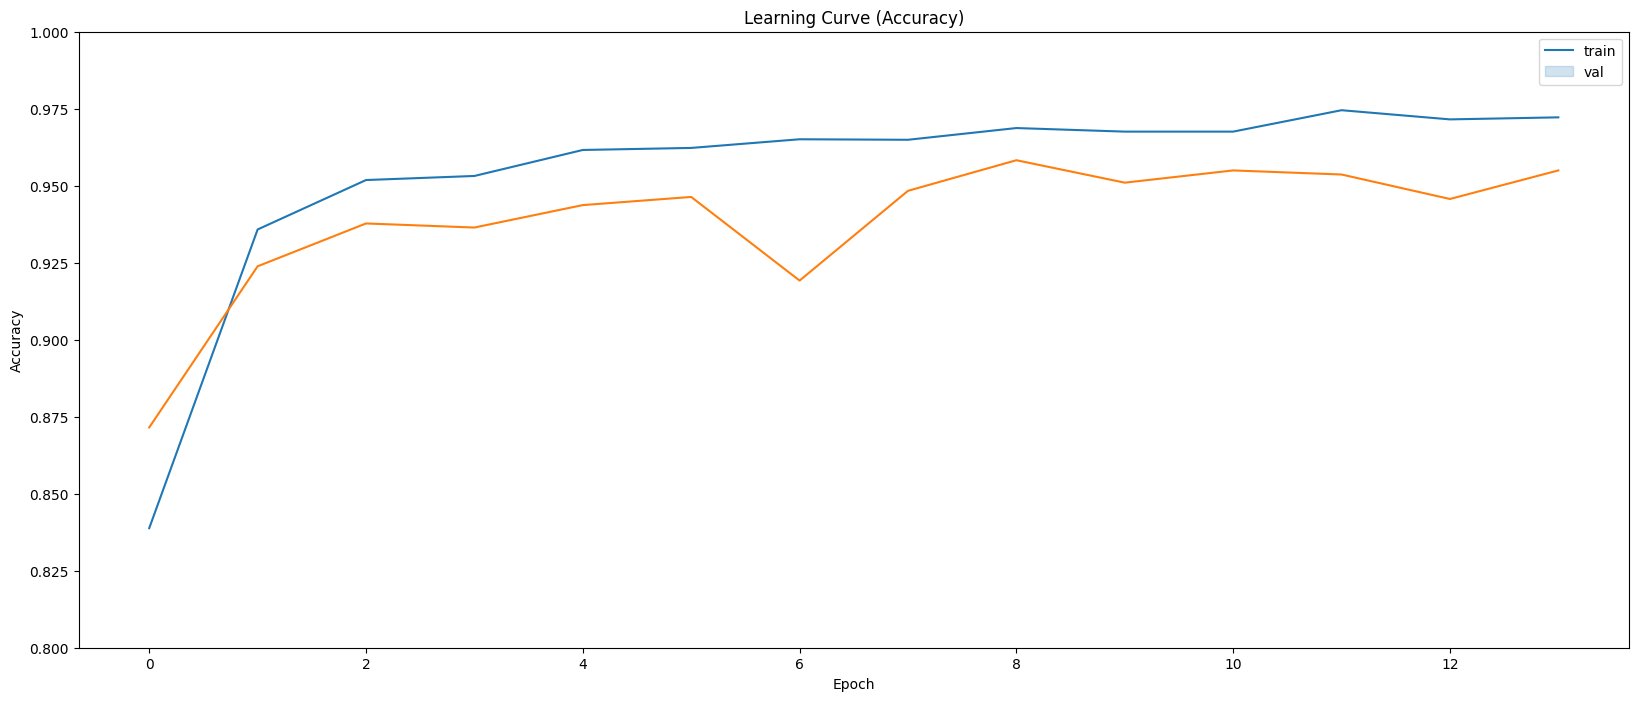

In [9]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['accuracy']) # Changed 'binary_accuracy' to 'accuracy'
sns.lineplot(x = history.epoch, y = history.history['val_accuracy']) # Changed 'val_binary_accuracy' to 'val_accuracy'
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [10]:
score = model_pretrained.evaluate(validation_data, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.10897237807512283
Val accuracy: 0.9602649211883545


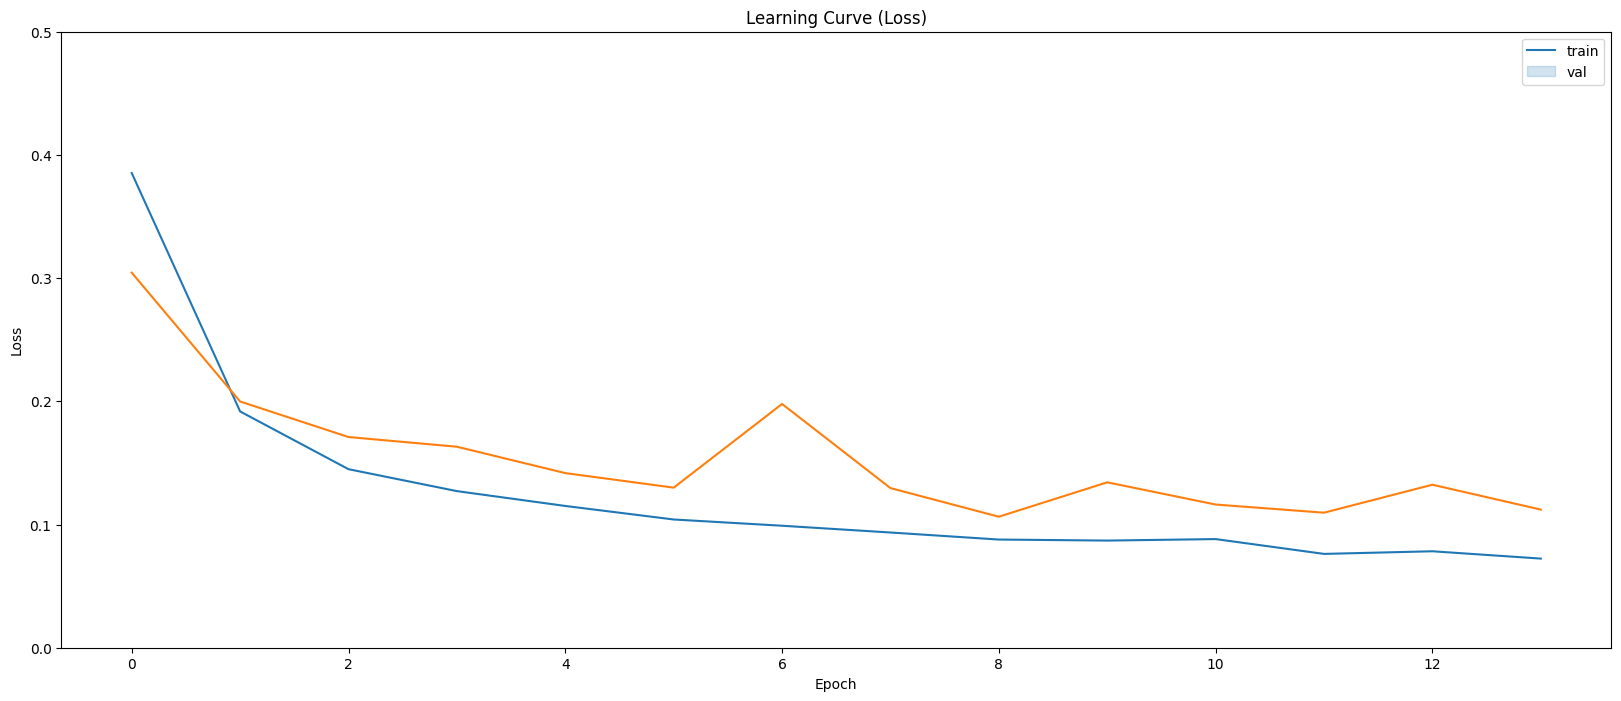

In [11]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()